# Global variables

In [35]:
# Interval of bins (a,b)
a = 190
b = 220
# Minimum count rate for fits
minCPS = 0.15

# Main code
Functions for data analysis

In [36]:
import h5py
import os
import sys
from glob import glob
from math import factorial, ceil, floor
from numpy import genfromtxt, sum, array,sqrt,zeros,exp,diag, pi,arange, sin, cos,vstack,log, mean, ones
from pylab import show, subplots_adjust,tight_layout, axis,xticks,yticks,savefig, errorbar, scatter,legend, colorbar, xlabel, ylabel, title, imshow,plot, subplot, axvspan,xlim,ylim,stem,setp
from matplotlib import gridspec
from scipy.optimize import curve_fit


## SORTING AND ORGANIZATION #############################
#########################################################
# Returns a list with combined data bins
def reduceBins(histograms,comb):
    reducedBinHistograms = []
    n = 0
    for i in histograms:
        combBins = []
        for j in range(0,len(i[0]),comb):
            s = 0
            for k in range(comb):
                if (j+k) < len(i[0]):
                    s += i[0][j+k]
            combBins.append(s)
        reducedBinHistograms.append([array(combBins), i[1], i[2]])

    return reducedBinHistograms


# Returns lists of the data split by the total time
def sort_and_split_by_time(histograms,remover=0):
    sortedHistograms = sort_mesurements_by_time(histograms,remover)
    values = 1
    for i in range(len(sortedHistograms)):
        if i != (len(sortedHistograms)-1):
            if sortedHistograms[i][1] != sortedHistograms[i+1][1]:
              values +=1
    print len(sortedHistograms)
    splitHistogramList = []
    for i in range(values):
        splitHistogramList.append([])

    n = 0
    for i in range(values):
        splitHistogramList[i].append(sortedHistograms[n])
        n +=1
        for j in range(n,len(sortedHistograms)):
            if sortedHistograms[j][1] == splitHistogramList[i][-1][1]:
                splitHistogramList[i].append(sortedHistograms[j])
                n += 1
            else:
                break
    return splitHistogramList


# Sorts histograms from shortest time to longest
def sort_mesurements_by_time(histograms, remover=0):
    # Parameters--|
    # ---------------------------------------------------------
    # event       | list => [counts (1D array), time, filenames]
    # ---------------------------------------------------------
    # Returns-----|
    # ---------------------------------------------------------
    # histogramsByTime| list => [counts (1D array), time, filenames]

    histogramsByTime = []
    temp = []
    addedFiles = []

    # Sort data
    for i in histograms:
        temp.append(i[1])
    while len(temp) != 0:
        for j in histograms:
            if j[1] == min(temp) and (j[2] not in addedFiles):
                histogramsByTime.append(j)
                addedFiles.append(j[2])
                temp.remove(min(temp))
                break
    indexList = []
    if remover==1:
        for i in range(len(histogramsByTime)):
            if (sum(histogramsByTime[i][0])/ histogramsByTime[i][1]) < minCPS:
                indexList.append(i)
        m = 0
        for n in indexList:
            histogramsByTime.pop(n-m)
            m += 1
    return histogramsByTime


## EQUATIONS ############################################
#########################################################
# Gaussian curve equation function
def gaussian_curve(x, a1, p1, w1, a2=0, p2=0, w2=0, doubleGauss=0):
    # Parameters |
    #---------------------------
    # x          | bin number
    # a          | amplitude
    # p          | peak pos.
    # w          | width

    return a1*exp(-(4*log(2)*(x-p1)**2)/(w1**2))+a2*exp(-(4*log(2)*(x-p2)**2)/(w2**2))   # In tedata of FWTM


# Returns the values corresponding to a Poisson function
def poisson_distribution(ocurrences,rate):
    # Parameters |
    #-------------------------
    # ocurrences | number of counts
    # rate       | count rate

    return (rate**ocurrences)/(factorial(ocurrences)*exp(rate))


# Returns the reduced Chi Square for a fit
def chi2_test(observed,expected):
    # Parameters |
    #-------------------------------------------
    # observed   | array/list of measured values
    # expected   | array/list of the fit
    # wholeFit   | = 0 for individual Gaussian fits
    # ^^^^^^^^^^^| = 1 for both Gaussians fit

    chi2 = 0
    for i in range(len(observed)):
        chi2 += ((observed[i]-expected[i])**2)/expected[i]
    return chi2/(len(observed)-6)


## PLOTS AND FITTING ####################################
#########################################################
# Plots the frequency of measurement of each count value
def count_frecuency(bns, allCPS):
    # Parameters |
    #-------------------------------------------
    # bns        | list => [multidimensional arrays (counts in bins)]
    # allCPS     | list/array => [counts per second on each histogram]

    counts = []
    reps = []
    frec = []
    totalMeasurements = 0
    for i in bns:
        for j in range(i.shape[0]):
            for k in range(i.shape[1]):
                c = i[j][k]
                if c not in counts:
                    counts.append(c)
                    reps.append(1)
                else:
                    n = counts.index(c)
                    reps[n] += 1
        totalMeasurements += i.shape[0]*i.shape[1]
    for i in reps:
        frec.append(float(i)/totalMeasurements)
    scatter(counts,frec)

    averageCPS = mean(array(allCPS))
    fit = []
    for i in range(len(counts)):
        fit.append(poisson_distribution(i,averageCPS))
    plot(counts,fit,"--r", label="Poisson dist.", zorder=1)
    chi2 = chi2_test(frec,fit)
    xlabel("Counts")
    ylabel("Frequency")
    legend(loc="upper right")
    title("Count frequency")
    show()
    
    
# Returns a list with the fit values
def gaussian_fit(y, t1a, t2a, t3a, x1, x2,t1b=0, t2b=0, t3b=0):
    # Parameters |
    #--------------------------------------------------
    # y          | list/array of measured y values
    # t1         | test parameter 1 (amplitude)
    # t2         | test parameter 2 (peak position
    # t3         | test parameter 3 (width)
    # x1         | start of interval to find fit param.
    # x2         | end of interval

    initValues = [t1a,t2a,t3a,t1b,t2b,t3b]

    fitValues = curve_fit(gaussian_curve,range(x1,x2),y,p0 = initValues)

    amp1 = fitValues[0][0]
    pkPos1 = fitValues[0][1]
    width1 = fitValues[0][2]

    paramErrors = sqrt(diag(fitValues[1]))

    amp1Err = paramErrors[0]
    pkPos1Err = paramErrors[1]
    width1Err = paramErrors[2]
    
    fit = []
    
    amp2 = fitValues[0][3]
    pkPos2 = fitValues[0][4]
    width2 = fitValues[0][5]

    amp2Err = paramErrors[3]
    pkPos2Err = paramErrors[4]
    width2Err = paramErrors[5]
        
    for i in range(x1,x2):
        fit.append(gaussian_curve(i,amp1,pkPos1,width1, a2=amp2,p2=pkPos2,w2=width2))
    fitData = [fit,amp1,pkPos1,abs(width1),amp2,pkPos2,abs(width2),amp1Err,pkPos1Err,width1Err,amp2Err,pkPos2Err,width2Err]
    
    return fitData


# Plot bin histogram image
def plot_stacked_histograms_image(bns,sect=0):
    # Parameters |
    #------------------------------------------------------
    # bns        | list => [multidimensional arrays (counts in bins)]

    imshow(vstack(bns), origin='0', aspect="auto",cmap="plasma")
    if sect==1:
        axvspan(0,a, alpha=0.30, facecolor="black")               # Highlight selected
        axvspan(b,len(bns[1][0])-1, alpha=0.3, facecolor="black") # interval
    ylabel("Periods")
    xlabel("Bins")
    colorbar().set_label("Counts")
    

# Plot the angular response
def plot_angular_response(az, el, cps, plotHistograms=0,histograms=[],remover=0, highlightArea=0):
    # Parameters |
    #------------------------------------------------------
    # az         | list containing azimuth values
    # el         | list containing elevation values
    # cps        | list containing counts per second values

    angle = arange(0, 2 * pi, 0.01)
    for i in range(0,36,5):
        if highlightArea==1 and i == 25:
            plot(i * cos(angle), i * sin(angle), "-r", zorder=1)
        else:
            plot(i * cos(angle), i * sin(angle), "--k", alpha=0.25, zorder=1)

    if plotHistograms==0:
        if remover ==1:
            az1 = []
            el1 = []
            cps1 = []
            for i in range(len(cps)):
                if cps[i] > minCPS:
                    az1.append(az[i])
                    el1.append(el[i])
                    cps1.append(cps[i])
        else:
            az1 = az
            el1 = el
            cps1 = cps
        
        scatter(az1, el1, c=cps1, zorder=2,cmap="plasma")
        xlabel("Azimuth (deg)")
        ylabel("Elevation (deg)")
        xlim(-40,40)
        ylim(-40,40)
        colorbar().set_label("Counts/sec")
        
    elif plotHistograms==1:
        for i in range(len(histograms)):
            a = -1*(el[i]/5)+7
            n = (az[i]/5 + 7)+1 + a*15
            subplot(15,15,int(n))
            if remover == 1 and (cps[i] < minCPS or histograms[i][1] == 1025.0):
                plot(histograms[i][0], label = str(histograms[i][1])+" sec", color='red')
            else: 
                plot(histograms[i][0], label = str(histograms[i][1])+" sec")
            axis('square')
            xticks([])
            yticks([])
        
            
# Plot 2 gaussian fits for the data
def fit_histograms(histogramList, returnFitParam=0, noRMS=0, remover=0,
                   customInitialParameters=0,amp1=0,pkPos1=0,width1=0,amp2=0,pkPos2=0,width2=0, reduceBin=1, normalization=0):
    
    # Parameters     |
    #--------------------------------------------------------------
    # histogram          | list => [counts (1D array), time, filenames]
    # returnFitParam | = 0 plots the 2 gaussian fits
    # ^^^^^^^^^^^^^^^| = 1 returns list with fit parameters
    
    
    if reduceBin != 0:
        histograms = reduceBins(histogramList,reduceBin)
        if len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))  
    
    s = zeros(len(histograms[0][0]), float)
    if noRMS==0:
        for i in range(len(histograms)):
            # Sum squares
            s += (histograms[i][0])**2
        m = s / len(histograms)
        data = sqrt(m)
    elif noRMS==1:
        for i in range(len(histograms)):
            s += (histograms[i][0])
        data = s
        
    if normalization!=0:
        data = (data/max(data))*normalization
        
    if customInitialParameters==0:
        amp1 = max(data)
        pkPos1 = a1+(list(data).index(max(data)))
        width1 = 10/reduceBin

        amp2 = max(data[int((pkPos1-a1+10/reduceBin)):])
        pkPos2 = pkPos1+13/reduceBin
        width2 = 10/reduceBin

    fitData = gaussian_fit(data,amp1,pkPos1,width1,a1,b1,t1b=amp2,t2b=pkPos2,t3b=width2)
    fit = fitData[0]
    chi2Fit = chi2_test(data,fit)
    print chi2Fit

    if returnFitParam:
        return [fitData,chi2Fit]
    else:
        plot(range(a1,b1),data,"--o", label="Data")
        plot(range(a1,b1),fit,"--",label=r"Fit ($\chi^2$ = " +str(round(chi2Fit,2)) + ")", linewidth=2, zorder=3)
        plot(range(a1,b1), gaussian_curve(arange(a1,b1), fitData[1],fitData[2],fitData[3]), alpha=0.5)
        plot(range(a1,b1), gaussian_curve(arange(a1,b1), fitData[4],fitData[5],fitData[6]), alpha=0.5)
        ylabel("Counts")
        xlabel("Bin Number")
        legend(loc="upper right")
        

# Plot counts vs bins for each individual histogram array
def plot_all_histograms(histograms, removeBad=0,ordered=0):
    # Parameters     |
    #--------------------------------------------------------------
    # histogram          | list => [counts (1D array), time, filenames]
    
    if removeBad==1:
        ordered=1
    
    if ordered==1:
        sortedHistograms = sort_mesurements_by_time(histograms,remover=removeBad)
    elif ordered==0:
        sortedHistograms=histograms
    
    n=0
    for i in sortedHistograms:
        subplot(6,9,n+1)
        plot(range(a,b),i[0], label = str(i[1])+" sec")
            
        title(str(n+1), fontweight='bold')
        legend(loc="upper right")
        n+=1
    show()

# Plot residual of the fit
def plot_residual(histogramList, noRMS=0, reduceBin=1, normalization=0):
    # Parameters     |
    # -------------------------------------------------------------
    # histogram          | list => [counts (1D array), time, filenames]
    
    if reduceBin != 0:
        histograms = reduceBins(histogramList,reduceBin)
        if len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(ceil(float(a)/reduceBin)), int(floor(float(b)/reduceBin)))):
            a1 = int(ceil(float(a)/reduceBin))
            b1 = int(floor(float(b)/reduceBin))
        elif len(histograms[0][0]) == len(range(int(floor(float(a)/reduceBin)), int(ceil(float(b)/reduceBin)))):
            a1 = int(floor(float(a)/reduceBin))
            b1 = int(ceil(float(b)/reduceBin))
    
    s = zeros(len(histograms[0][0]), float)
    if noRMS == 0:
        for i in range(len(histograms)):
            # Sum squares
            s += (histograms[i][0]) ** 2
        m = s / len(histograms)
        data = sqrt(m)
    elif noRMS==1:
        for i in range(len(histograms)):
            s += (histograms[i][0])
        data = s
        
    if normalization!=0:
        data = (data/max(data))*normalization

    amp1 = max(data)
    pkPos1 = a1+(list(data).index(max(data)))
    width1 = 10/reduceBin

    amp2 = max(data[int((pkPos1-a1+10/reduceBin)):])
    pkPos2 = pkPos1+13/reduceBin
    width2 = 10/reduceBin

    totalFit = gaussian_fit(data,amp1,pkPos1,width1,a1,b1,t1b=amp2,t2b=pkPos2,t3b=width2)[0]
    
    chi2 = chi2_test(data, totalFit)
    residual = array(data) - array(totalFit)
    stem(range(a1,b1),residual,"--c","oc", label="Residual")
    xlabel("Bin Number")
    ylabel("Residual")
    legend(loc="upper right")
    
    
# Plot RMS fits and residuals
def plot_histogram_fit_and_residual(histogramList, remover=0, groupByTime=0, noRMS=0, reduceBin=1, normalization=0):
    # Parameters     |
    # ------------------------------------------------------------------------------
    # histogram          | list => [counts (1D array), time, filenames]

    histograms = histogramList
    
    if groupByTime == 1:
            histogramsByTime = sort_and_split_by_time(histograms, remover)
            histogramsByTime.pop(len(histogramsByTime)-2) # Remove the 1025s histogram (bad fit, high chi2)
            n = 0
            outerGrid = gridspec.GridSpec(2, 3)
            for i in histogramsByTime:
                print len(histogramsByTime)
                innerGrid = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outerGrid[n])
                sp1 = subplot(innerGrid[0])
                title(str(i[0][1]) + "s ("+str(len(i))+")",fontweight='bold')
                fit_histograms(i, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization)
                sp2 = subplot(innerGrid[1])
                plot_residual(i, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization)
                setp(sp1.get_xticklabels(), visible=False)
                n += 1
            show()

    elif groupByTime == 0:
        sp1 = subplot(211)
        title("All Histograms", fontweight = 'bold')
        fit_histograms(histograms, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization,remover=remover)
        subplot(212,sharex=sp1)
        plot_residual(histograms, noRMS=noRMS,reduceBin=reduceBin,normalization=normalization, remover=remover)
        setp(sp1.get_xticklabels(), visible=False)
        show()

        
# Plot parameter data from the fits
def plot_fit_parameters(histograms, remover=0, noRMS=0, normalization=0,reduceBin=1,returnList=0):
    # Parameters     |
    # -------------------------------------------------------------
    # histogram          | list => [counts (1D array), time, filenames]
    # s              | int => number of histograms in one section

    listOfFitParameters = []
    
    chi2F1 = []
    ampF1 = []
    pkPosF1 = []
    widthF1 = []

    ampErrF1 = []
    pkPosErrF1 = []
    widthErrF1 = []

    chi2F2 = []
    ampF2 = []
    pkPosF2 = []
    widthF2 = []

    ampErrF2 = []
    pkPosErrF2 = []
    widthErrF2 = []
    
    Chi2 = []
    
    times = []
    histogramsByTime = sort_and_split_by_time(histograms,remover)
    histogramsByTime.pop(len(histogramsByTime)-2) # Remove the 1025s histogram (bad fit, high chi2)
    for i in histogramsByTime:
        times.append(str(i[0][1])+"s")
        listOfFitParameters.append(fit_histograms(i,normalization=normalization,reduceBin=reduceBin,noRMS=noRMS,returnFitParam=1))

    for i in listOfFitParameters:
        Chi2.append(i[1])           # |__[[fitData,chi2Fit]]
        ampF1.append(i[0][1])       #         |         |__number
        pkPosF1.append(i[0][2])     #         |____list => [i] = [fit,amp,pkPos,width,ampErr,pkPosErr,widthErr]
        widthF1.append(i[0][3])     
        ampF2.append(i[0][4])
        pkPosF2.append(i[0][5])
        widthF2.append(i[0][6])

        ampErrF1.append(i[0][7])
        pkPosErrF1.append(i[0][8])
        widthErrF1.append(i[0][9])
        ampErrF2.append(i[0][10])
        pkPosErrF2.append(i[0][11])
        widthErrF2.append(i[0][12])

    allHistogramsFitParameters = fit_histograms(histograms,normalization=normalization,reduceBin=reduceBin,noRMS=noRMS,returnFitParam=1)
    
    times.append("All")
    print allHistogramsFitParameters[1]
    Chi2.append(allHistogramsFitParameters[1]) 
    ampF1.append(allHistogramsFitParameters[0][1])
    pkPosF1.append(allHistogramsFitParameters[0][2]) 
    widthF1.append(allHistogramsFitParameters[0][3])     
    ampF2.append(allHistogramsFitParameters[0][4])
    pkPosF2.append(allHistogramsFitParameters[0][5])
    widthF2.append(allHistogramsFitParameters[0][6])

    ampErrF1.append(allHistogramsFitParameters[0][7])
    pkPosErrF1.append(allHistogramsFitParameters[0][8])
    widthErrF1.append(allHistogramsFitParameters[0][9])
    ampErrF2.append(allHistogramsFitParameters[0][10])
    pkPosErrF2.append(allHistogramsFitParameters[0][11])
    widthErrF2.append(allHistogramsFitParameters[0][12])
    
    meanPkPos1 = mean(pkPosF1)
    meanPkPos2 = mean(pkPosF2)
    
    meanFWHM1 = mean(widthF1)
    meanFWHM2 = mean(widthF2)
    
    meanFWHMdev1 = array(widthF1)-meanFWHM1
    meanFWHMdev2 = array(widthF2)-meanFWHM2
    
    SNR1 = abs((array(widthErrF1)**(-1))*meanFWHM1)
    SNR2 = abs((array(widthErrF2)**(-1))*meanFWHM2)
    
   
    
    if returnList==0:
        subplot(511)
        plot(Chi2, label="$\chi^2$")
        xticks(range(len(Chi2)),times)
        legend(loc="upper left")

        sp1 = subplot(523)
        errorbar(range(len(pkPosF1)),pkPosF1,yerr=pkPosErrF1, color="r",label="Peak Position (Mean = "+str(round(meanPkPos1,2))+")")
        plot(ones(len(pkPosF1))*meanPkPos1, "--g")
        xticks(range(len(pkPosF1)),times)
        title("Peak 1", fontweight="bold")
        legend(loc="upper left")

        subplot(525,sharex=sp1)
        setp(sp1.get_xticklabels(), visible=False)
        plot(ones(len(widthF1))*meanFWHM1, "--g")
        errorbar(range(len(widthF1)),widthF1, yerr=widthErrF1,label="FWHM (Mean = "+str(round(meanFWHM1,2))+")")
        xticks(range(len(widthF1)),times, visible=False)
        legend(loc="upper left")
        
        subplot(527,sharex=sp1)
        setp(sp1.get_xticklabels(), visible=False)
        stem(range(len(widthF1)), meanFWHMdev1, label="Mean FWHM deviation")
        xticks(range(len(widthF1)),times, visible=False)
        legend(loc="upper left")
        
        subplot(529,sharex=sp1)
        setp(sp1.get_xticklabels(), visible=False)
        plot(range(len(widthF1)),SNR1, "--o", label="SNR")
        xticks(range(len(widthF1)),times)
        legend(loc="upper left")
        
        sp2 = subplot(524)
        errorbar(range(len(pkPosF2)),pkPosF2,yerr=pkPosErrF1, color ="r", label="Peak Position (Mean = "+str(round(meanPkPos2,2))+")")
        plot(ones(len(pkPosF2))*meanPkPos2, "--g")
        xticks(range(len(pkPosF2)),times)
        title("Peak 2", fontweight="bold")
        legend(loc="upper left")

        subplot(526, sharex=sp2)
        setp(sp2.get_xticklabels(), visible=False)
        plot(ones(len(widthF2))*meanFWHM2, "--g")
        errorbar(range(len(widthF2)), widthF2, yerr=widthErrF2, label="FWHM (Mean = "+str(round(meanFWHM2,2))+")")
        xticks(range(len(widthF2)),times, visible=False)
        legend(loc="upper left")
        
        subplot(528,sharex=sp2)
        setp(sp2.get_xticklabels(), visible=False)
        stem(range(len(widthF2)), meanFWHMdev2, label="Mean FWHM deviation")
        xticks(range(len(widthF2)),times, visible=False)
        legend(loc="upper left")
        
        subplot(5,2,10,sharex=sp2)
        setp(sp2.get_xticklabels(), visible=False)
        plot(range(len(widthF2)),SNR2, "--o", label="SNR")
        xticks(range(len(widthF2)),times)
        legend(loc="upper left")
       
    elif returnList==1:
        return listOfFitParameters

# Data extraction
From SXM angular response log files

In [3]:
h5FilesDir = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/h5_files"
logfilesTablePath = "/home/cnieves/PycharmProjects/CfA/flight_spare_data/data_table.txt"

tableData = genfromtxt(logfilesTablePath, str)   # Data from angular response measurements

# Gets all the .h5 files from the specified directory
if h5FilesDir.endswith("/"):
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)
else:
    h5FilesDir += "/"
    filePaths = sorted(glob(h5FilesDir + "*.h5"), key=os.path.getsize)

countsPerSec = []     # Contains cps for each bin
elevation = []        # Values for elevation (deg)
azimuth = []          # Values for azimuth (deg)
binList = []          # Contains the arrays for each individual 'bin'
eventsTimeList = []   # [All counts, total time, name of the file] to be sorted by time
counts = []           # All counts on each 'bin' array
counts1 = []
bns = []

for i in filePaths:
    fileName = i[len(h5FilesDir):(len(i) - len(".h5"))]

    # Find files in the directory that match with the files on the table
    for m in tableData:
        if m[2] == fileName:  # m[2] is the logfile name on table

            # Calculate counts per second
            dataFile = h5py.File(i)
            binList.append(dataFile['data/tlm_sxm_data/hdr']['bin'])
            bins = dataFile['data/tlm_sxm_data/hdr']['bin'][:, a:b]
            dataFile.close()

            s = sum(bins, 1)
            totalTime = float(32 * len(s) / 2 + 18 * len(s) / 2)
            totalCounts = sum(bins)
            totalCounts1 = sum(bins[:35,:])
            cps = totalCounts / totalTime

            azimuth.append(float(m[0]))
            elevation.append(float(m[1]))
            countsPerSec.append(cps)
            eventsTimeList.append([sum(bins,0), totalTime, fileName])
            counts.append(totalCounts)
            counts1.append(totalCounts1)
            bns.append(bins)

<IPython.core.display.Javascript object>


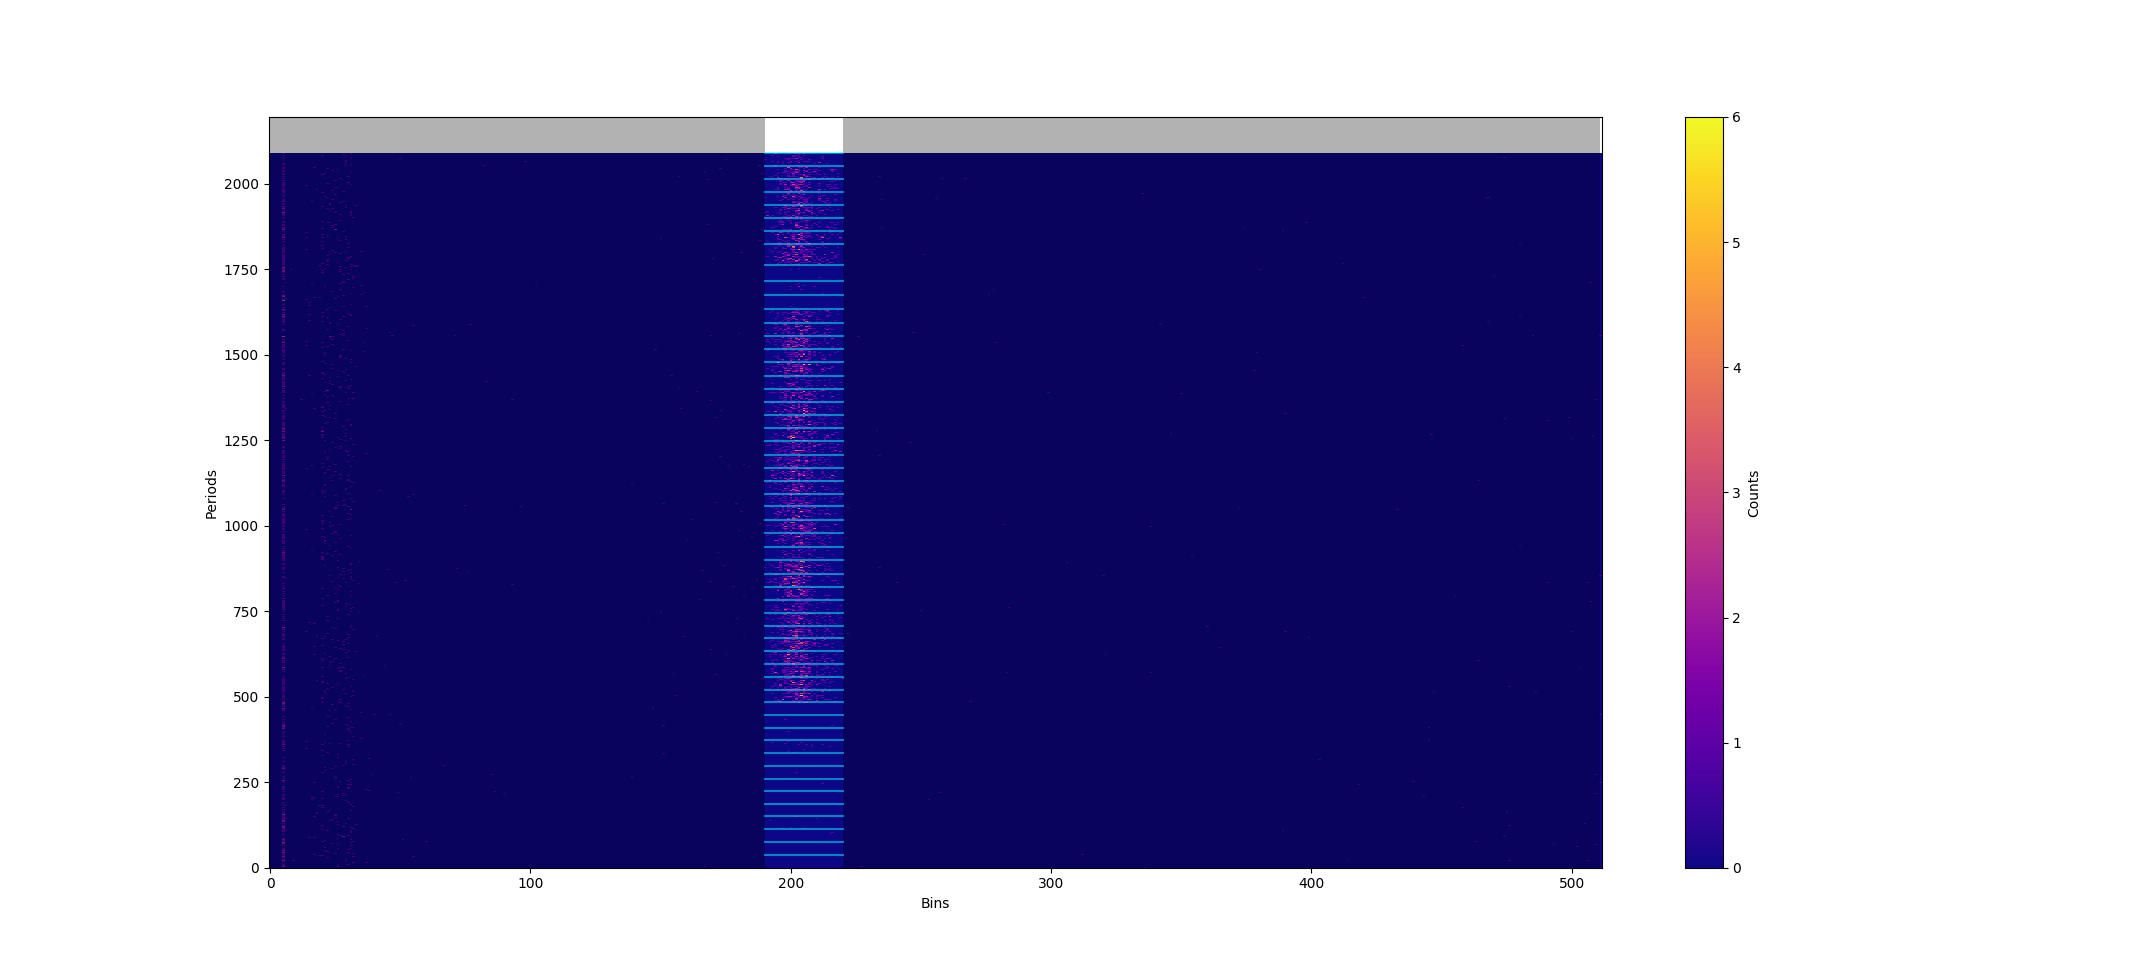

In [51]:
%matplotlib notebook
plot_stacked_histograms_image(binList, sect=1)
c = 0
for i in binList:
    plot(range(a,b+1),ones(len(range(a,b+1)))*(i.shape[0])+c, color='cyan', alpha=.5)
    c += i.shape[0]

<IPython.core.display.Javascript object>


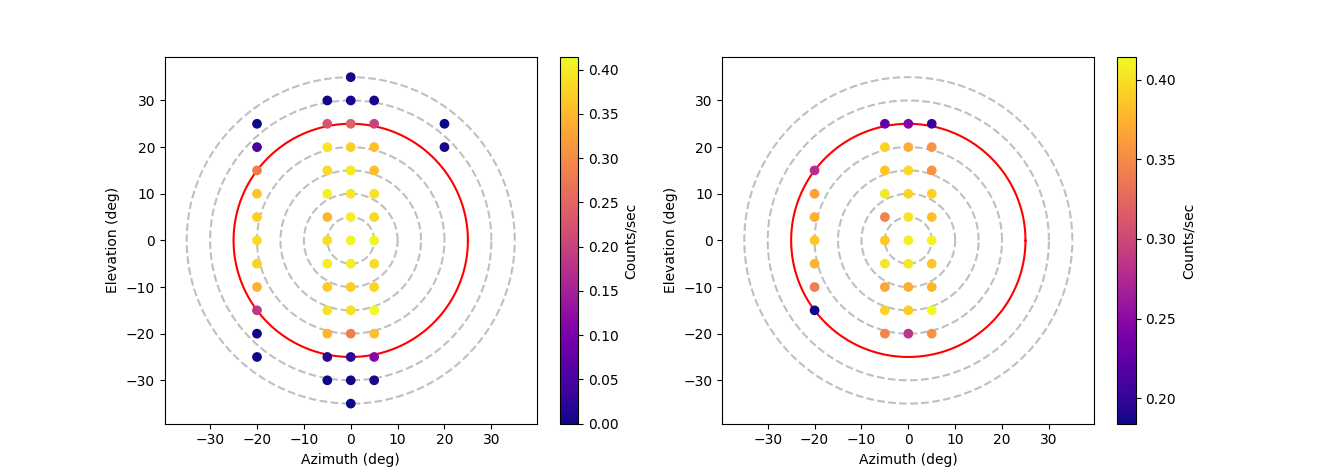

(-38.49995339098708, 38.499997780523195, -38.49989457487935, 38.49998335392343)

In [8]:
%matplotlib notebook
subplot(121)
plot_angular_response(azimuth,elevation, countsPerSec,histograms=eventsTimeList, remover=0, highlightArea=1)
axis("equal")
subplot(122)
plot_angular_response(azimuth,elevation, countsPerSec,histograms=eventsTimeList, remover=1, highlightArea=1)
axis("equal")


<IPython.core.display.Javascript object>


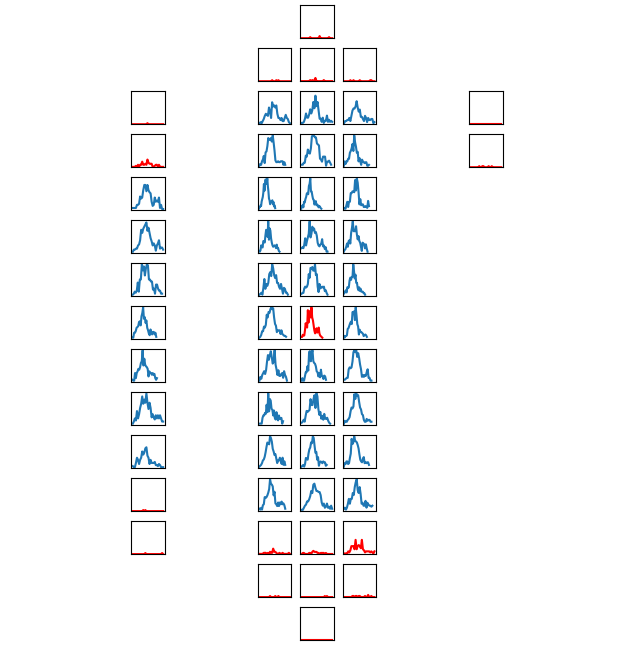

In [53]:
%matplotlib notebook
plot_angular_response(azimuth,elevation, countsPerSec,plotHistograms=1,histograms=eventsTimeList, remover=1)
tight_layout(pad=0.01)

<IPython.core.display.Javascript object>


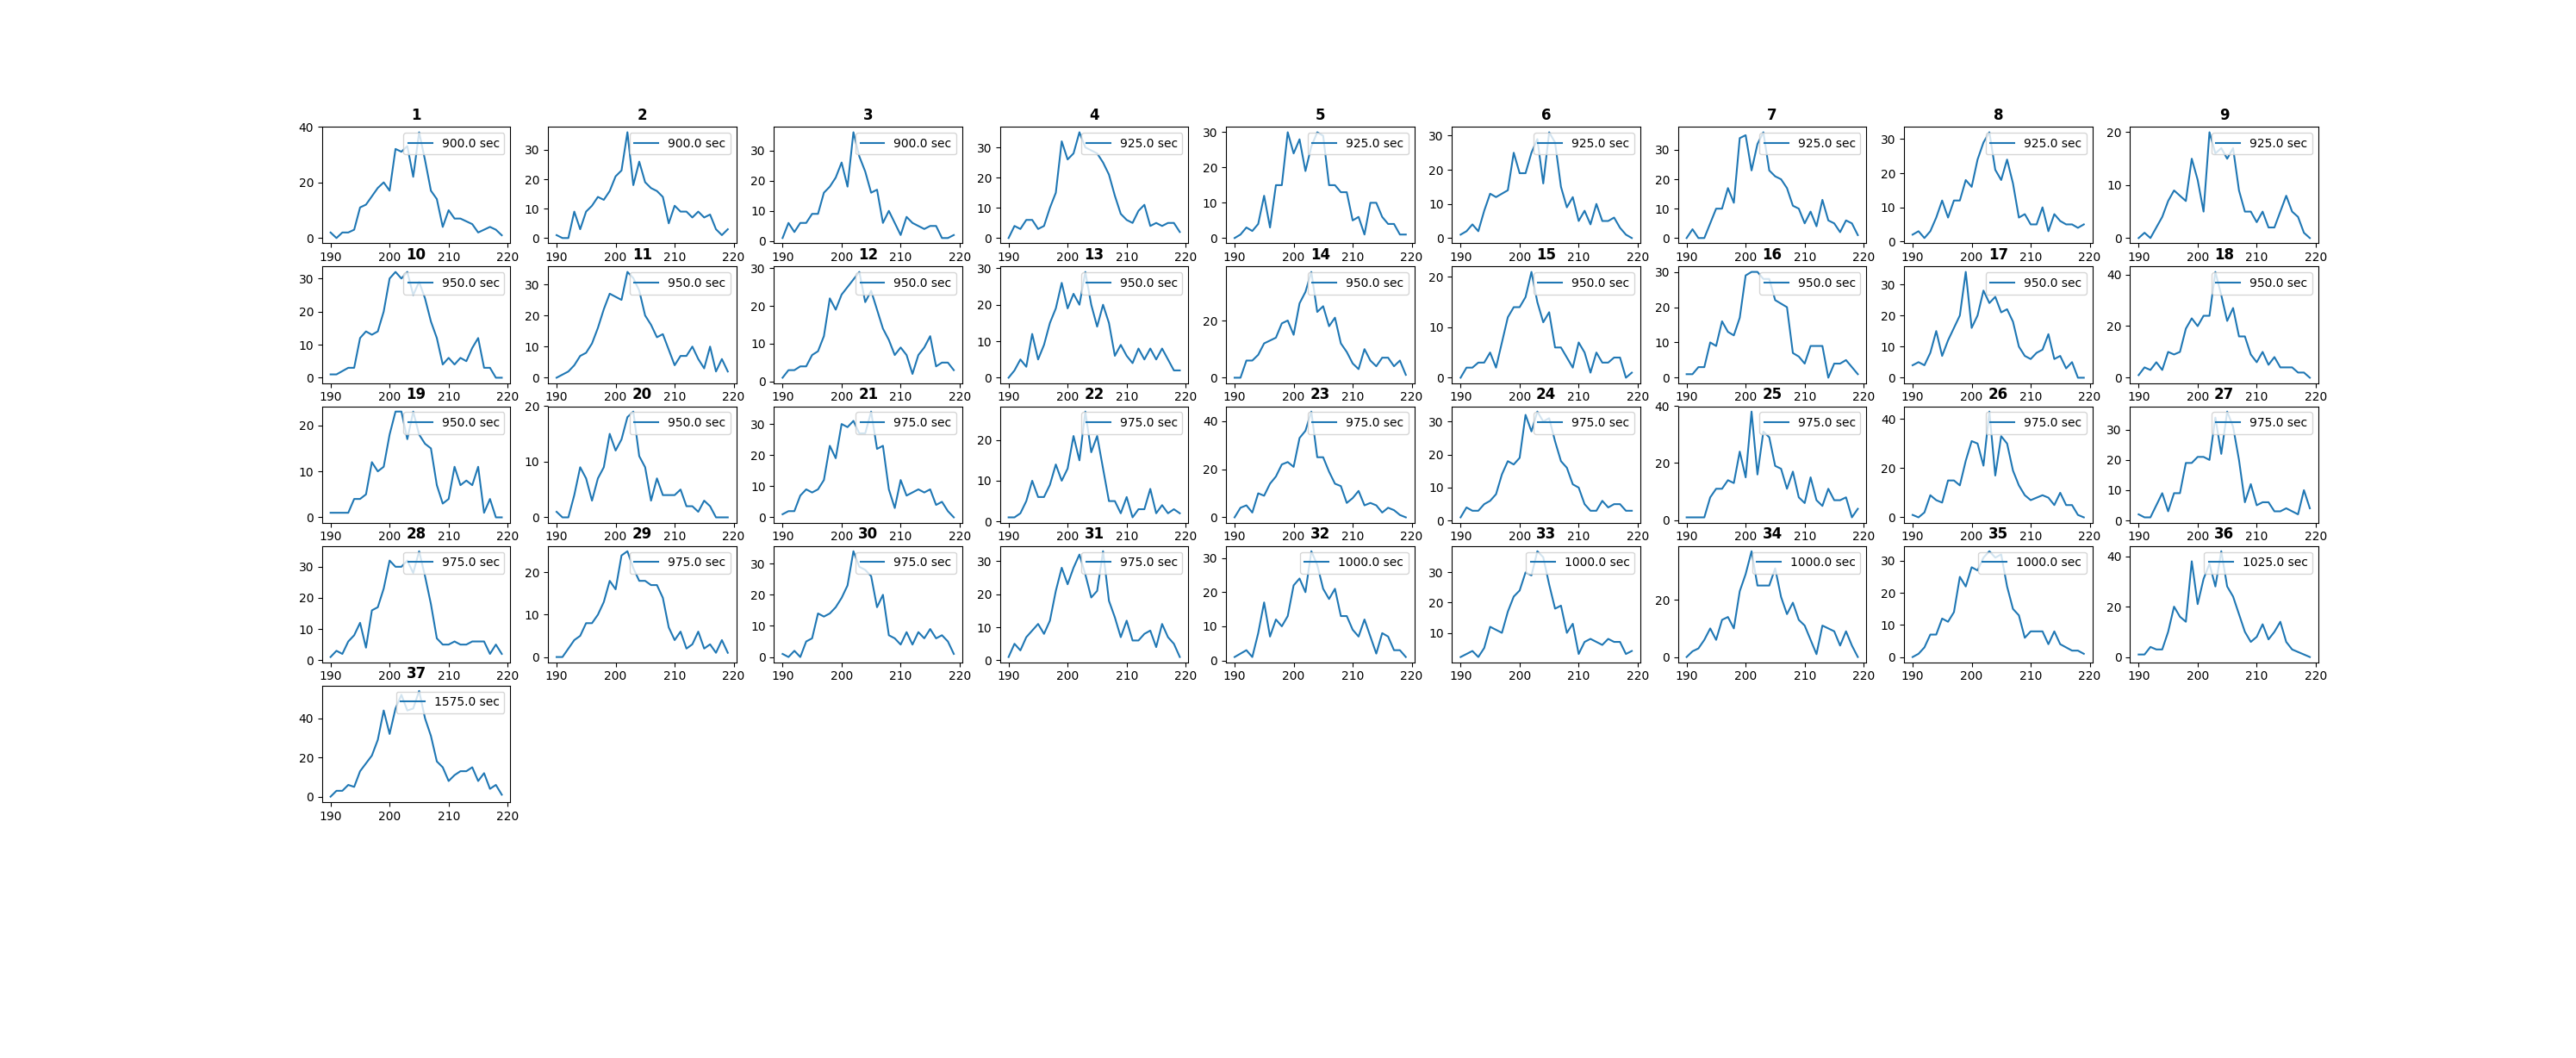

In [57]:
%matplotlib notebook
plot_all_histograms(eventsTimeList, removeBad=1, ordered=1)


<IPython.core.display.Javascript object>


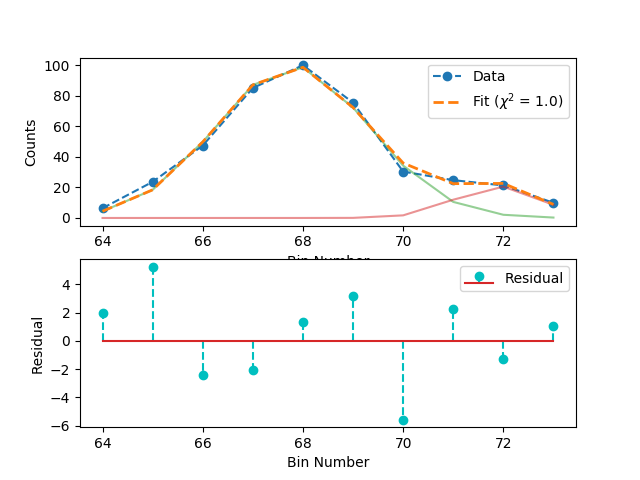

0.9986035930606373


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


In [8]:
%matplotlib notebook
subplot(211)
fit_histograms(eventsTimeList, normalization=100, reduceBin=3, noRMS=1)
subplot(212)
plot_residual(eventsTimeList, normalization=100, reduceBin=3, noRMS=1)

37
6


<IPython.core.display.Javascript object>


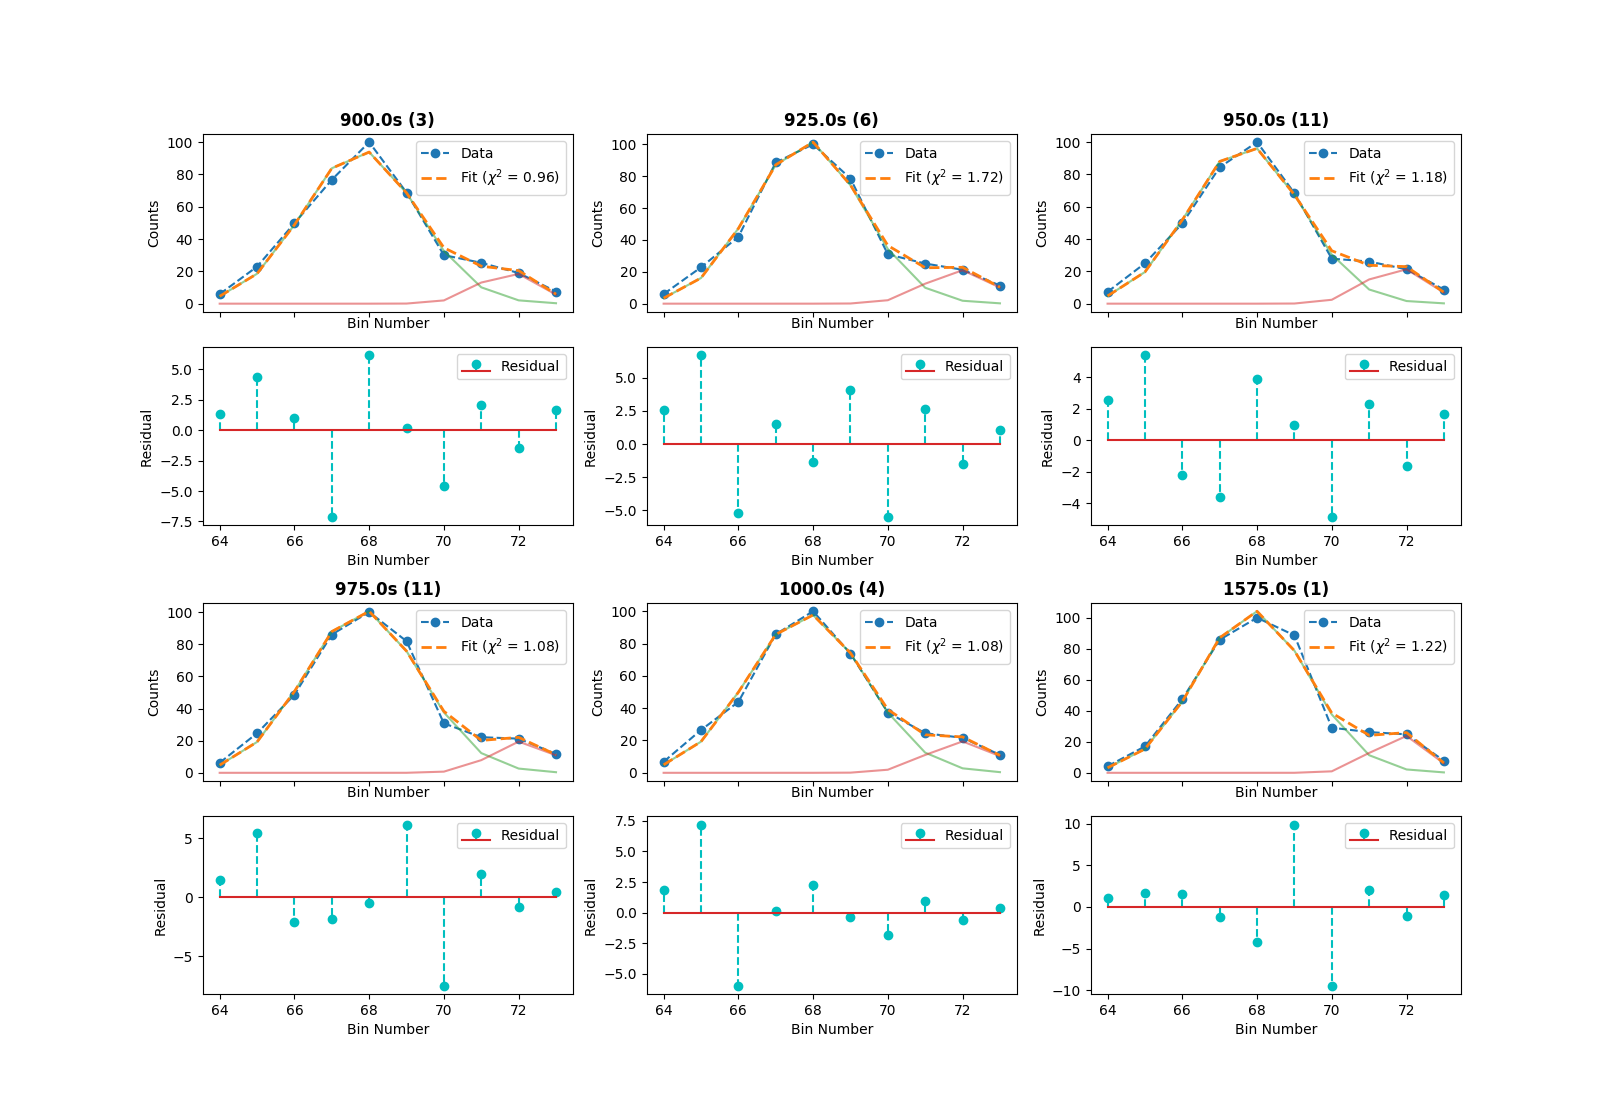

6


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: divide by zero encountered in divide


6
6
6
6


In [63]:
%matplotlib notebook
plot_histogram_fit_and_residual(eventsTimeList, reduceBin=3, normalization=100, noRMS=1, groupByTime=1, remover=1)

37
0.9558957181776387
1.7224476064943652
1.1771575061463613
1.0839272853733475
1.0836680103799892
1.2203598983335437
0.9986035930606373
0.9986035930606373


<IPython.core.display.Javascript object>


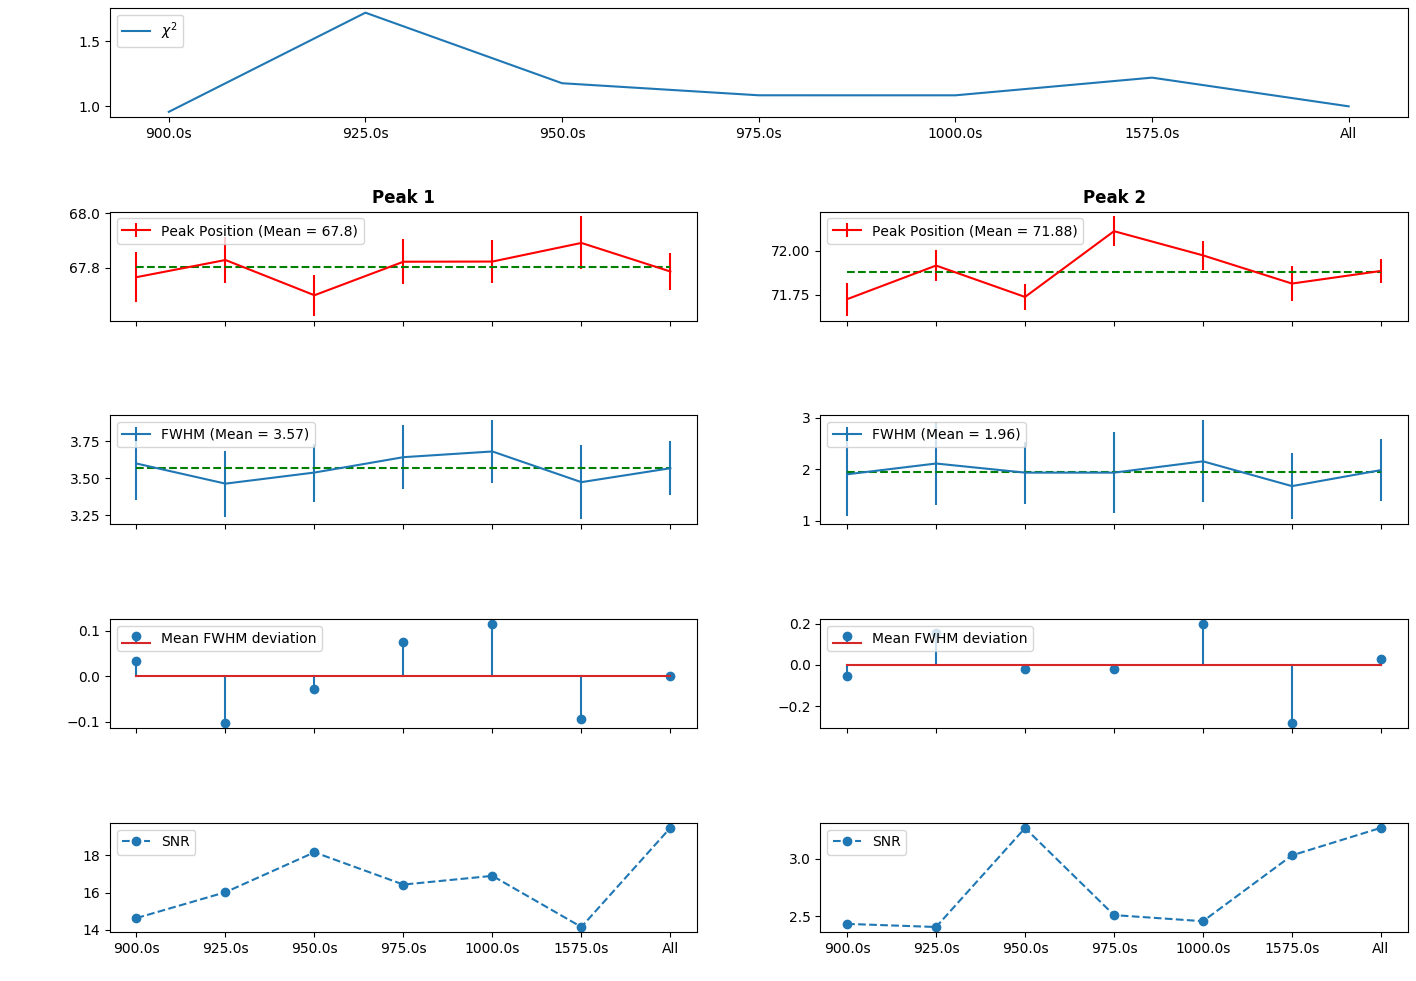

In [29]:
%matplotlib notebook
plot_fit_parameters(eventsTimeList,noRMS=1,reduceBin=3, normalization=100, remover=1)
tight_layout(pad=.02)

In [24]:
a = array([5,2,4,6],float)
m = mean(a)
stDev = sqrt(sum((a-m)**2)/len(a))
print stDev, sqrt(sum((a-m)**2)/len(a))

1.479019945774904 1.479019945774904
